In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
# No. of rows & Columns and datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [4]:
# Null Values

df.isnull().sum()

Review    0
Rating    0
dtype: int64

# Wordcloud

In [5]:
from wordcloud import WordCloud
wc = WordCloud(width=700,
               height=400,
               background_color='white',
               min_font_size=10)

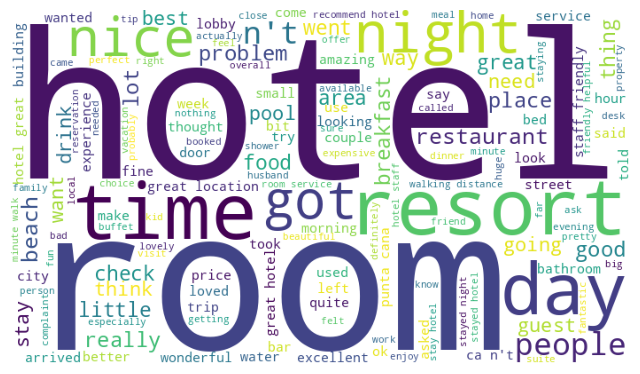

In [6]:
wc.generate(''.join(df['Review']))
plt.figure(figsize=(8,8))
plt.imshow(wc)
plt.axis('off')
plt.show()

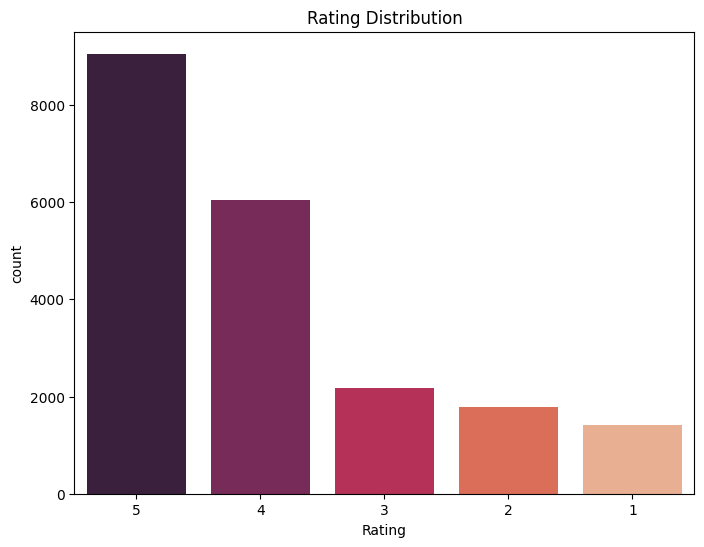

In [7]:
plt.figure(figsize=(8,6))
sns.countplot(data=df,
              x='Rating',
              palette="rocket",
              order = df['Rating'].value_counts().index)

plt.title('Rating Distribution')

plt.show()

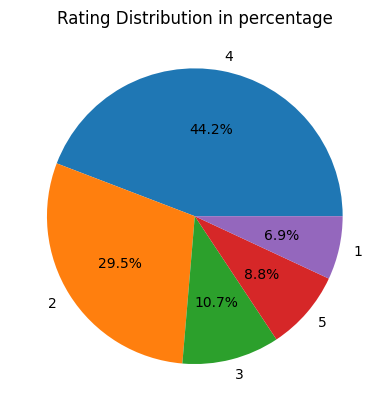

In [8]:
plt.pie(df['Rating'].value_counts(), labels=df['Rating'].unique().tolist(), autopct='%1.1f%%')
plt.title('Rating Distribution in percentage')
plt.show()

# Text Preprocessing

In [9]:

def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Netral'
    else:
        return 'Bad'

In [10]:
df['Rating'] = df['Rating'].apply(rating)

In [11]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,Good
1,ok nothing special charge diamond member hilto...,Bad
2,nice rooms not 4* experience hotel monaco seat...,Netral
3,"unique, great stay, wonderful time hotel monac...",Good
4,"great stay great stay, went seahawk game aweso...",Good


In [12]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer

In [13]:
# Creating a Function clean_text for text preprocessing

def clean_text(text):
    stop = stopwords.words('english')
    punc = list(punctuation)
    bad_tokens = stop + punc
    lemma = WordNetLemmatizer()
    tokens = word_tokenize(text)
    word_tokens = [t for t in tokens if t.isalpha()]
    clean_token = [lemma.lemmatize(t.lower()) for t in word_tokens if t not in bad_tokens]
    return " ".join(clean_token)

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
df['Review'] = df['Review'].apply(clean_text)

In [16]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,Good
1,ok nothing special charge diamond member hilto...,Bad
2,nice room experience hotel monaco seattle good...,Netral
3,unique great stay wonderful time hotel monaco ...,Good
4,great stay great stay went seahawk game awesom...,Good


# Splitting target and feature columns

In [17]:
X = df['Review']
y = df['Rating']

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SimpleRNN, LSTM, GRU
from tensorflow.keras import regularizers
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [19]:

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.25)

# Checking No. of words in each sentence of Review column

In [20]:
sent_len = []
for sent in df['Review']:
    sent_len.append(len(word_tokenize(sent)))
df['sent_len'] = sent_len
df.head()

,Review,Rating,sent_len
0,nice hotel expensive parking got good deal sta...,Good,79
1,ok nothing special charge diamond member hilto...,Bad,223
2,nice room experience hotel monaco seattle good...,Netral,183
3,unique great stay wonderful time hotel monaco ...,Good,82
4,great stay great stay went seahawk game awesom...,Good,171


In [21]:
# Checking the reveiw with max no. of words

max(sent_len)

1752

In [22]:
pd.set_option('display.max_rows', None)
print(df['sent_len'].value_counts())

48      233
45      231
47      228
54      225
50      223
46      220
44      220
39      218
43      216
36      213
37      213
52      212
32      212
57      211
38      210
60      209
30      208
42      208
40      208
56      207
61      206
58      205
34      204
35      203
53      202
55      201
67      200
31      198
49      198
63      197
41      196
51      194
29      192
33      184
69      183
65      182
66      180
59      179
62      179
68      177
64      175
25      175
70      171
73      171
71      169
75      168
28      167
26      163
27      162
79      161
76      160
77      160
83      159
24      158
78      156
74      155
72      150
82      150
81      149
92      139
88      135
91      133
23      131
89      129
20      128
85      125
80      123
94      122
21      119
86      119
22      114
97      114
84      113
87      112
90      107
93      106
18      105
98      104
105     104
96      102
103     100
95      100
100      98
104 

In [23]:
# Removing 5% of data beacuse not all sentence length is 39 which is our max sent_len.

np.quantile(sent_len,0.95)

246.0

In [24]:
max_len = 246

# Tokenization, Vectorization & Padding Sequence

In [25]:
# Word tokenize on basis of spacing between each words

tok = Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(X_train)

In [26]:
# Index of all unique tokenized words

tok.index_word

{1: 'hotel',
 2: 'room',
 3: 'great',
 4: 'good',
 5: 'staff',
 6: 'stay',
 7: 'night',
 8: 'day',
 9: 'time',
 10: 'nice',
 11: 'location',
 12: 'service',
 13: 'stayed',
 14: 'restaurant',
 15: 'beach',
 16: 'breakfast',
 17: 'clean',
 18: 'place',
 19: 'food',
 20: 'resort',
 21: 'pool',
 22: 'like',
 23: 'really',
 24: 'bed',
 25: 'area',
 26: 'people',
 27: 'friendly',
 28: 'small',
 29: 'bar',
 30: 'little',
 31: 'walk',
 32: 'got',
 33: 'excellent',
 34: 'bathroom',
 35: 'view',
 36: 'best',
 37: 'minute',
 38: 'helpful',
 39: 'floor',
 40: 'trip',
 41: 'lot',
 42: 'water',
 43: 'recommend',
 44: 'price',
 45: 'went',
 46: 'make',
 47: 'thing',
 48: 'review',
 49: 'beautiful',
 50: 'desk',
 51: 'comfortable',
 52: 'want',
 53: 'problem',
 54: 'drink',
 55: 'right',
 56: 'way',
 57: 'better',
 58: 'city',
 59: 'street',
 60: 'free',
 61: 'wonderful',
 62: 'buffet',
 63: 'bit',
 64: 'away',
 65: 'booked',
 66: 'say',
 67: 'large',
 68: 'need',
 69: 'hour',
 70: 'new',
 71: 'quite'

In [27]:

unique_words = len(tok.index_word)
unique_words

37466

In [28]:
# Putting all index/unique id of each words in a sequence according to the data

sequences = tok.texts_to_sequences(X_train)
sequences

[[2154,
  293,
  136,
  489,
  925,
  119,
  222,
  102,
  209,
  2077,
  718,
  755,
  102,
  251,
  141,
  64,
  1,
  168,
  8,
  251,
  2,
  115,
  727,
  28,
  172,
  322,
  1356,
  1163,
  34,
  2938,
  4766,
  158,
  385,
  45,
  50,
  643,
  102,
  231,
  196,
  69,
  388,
  343,
  1426,
  34,
  2078,
  103,
  364,
  1024,
  2078,
  158,
  2,
  338,
  8,
  7,
  435,
  14366,
  131,
  5,
  1927,
  469,
  6],
 [3,
  1,
  923,
  659,
  235,
  1194,
  1754,
  123,
  98,
  1,
  646,
  190,
  6,
  711,
  37,
  31,
  1755,
  98,
  14367,
  148,
  2,
  17,
  16,
  84,
  4767,
  12071,
  3959,
  1928,
  125,
  29,
  14,
  1470,
  18915,
  197,
  43,
  1,
  130,
  51,
  126,
  106,
  6],
 [2466,
  27,
  28,
  1,
  1,
  2554,
  777,
  5569,
  274,
  48,
  2130,
  1,
  1352,
  2,
  74,
  25,
  1665,
  1047,
  404,
  157,
  548,
  140,
  5,
  71,
  27,
  2,
  286,
  18916,
  4316,
  115,
  146,
  797,
  904,
  42,
  3358,
  2218,
  635,
  5364,
  5044,
  325,
  1596,
  69,
  4768,
  1418,
  

In [29]:
# Padding Sequence

sequence_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
sequence_matrix

array([[    0,     0,     0, ...,  1927,   469,     6],
       [    0,     0,     0, ...,   126,   106,     6],
       [    0,     0,     0, ...,   715,  1007,  2130],
       ...,
       [    0,     0,     0, ...,  4519,    29,  1159],
       [    0,     0,     0, ...,     3,    72,     6],
       [    0,     0,     0, ..., 17875, 14834,   113]], dtype=int32)

In [30]:
# One hot encoding the label
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Model Building (Neural Network)

In [31]:
model = Sequential()
model.add(Embedding(unique_words+1,500,mask_zero=True))
model.add(GRU(16,activation='tanh'))                                                                                                                                                                     # GRU Layer
model.add(Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(Dense(3,activation='softmax'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 500)         18733500  
                                                                 
 gru (GRU)                   (None, 16)                24864     
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 18758527 (71.56 MB)
Trainable params: 18758527 (71.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
trained_model = model.fit(sequence_matrix,y_train,epochs=10)

Epoch 1/10
481/481 [==============================] - 275s 572ms/step - loss: 0.4374 - accuracy: 0.8527
Epoch 2/10
481/481 [==============================] - 271s 564ms/step - loss: 0.3825 - accuracy: 0.8647
Epoch 3/10
481/481 [==============================] - 271s 564ms/step - loss: 0.3519 - accuracy: 0.8716
Epoch 4/10
481/481 [==============================] - 269s 560ms/step - loss: 0.3183 - accuracy: 0.8775
Epoch 5/10
481/481 [==============================] - 272s 564ms/step - loss: 0.2905 - accuracy: 0.8827
Epoch 6/10
481/481 [==============================] - 273s 568ms/step - loss: 0.2685 - accuracy: 0.8872
Epoch 7/10
481/481 [==============================] - 273s 567ms/step - loss: 0.2473 - accuracy: 0.8997
Epoch 8/10
481/481 [==============================] - 269s 559ms/step - loss: 0.2290 - accuracy: 0.9140
Epoch 9/10
481/481 [==============================] - 273s 567ms/step - loss: 0.2060 - accuracy: 0.9282
Epoch 10/10
481/481 [==============================] - 265s 552m

In [36]:
sequence_matrix_test = sequence.pad_sequences(tok.texts_to_sequences(X_test),maxlen=max_len)

In [38]:
# Testing our model

Y_pred = model.predict(sequence_matrix_test)
print(np.round(Y_pred,3))

161/161 [==============================] - 10s 56ms/step
[[0.954 0.    0.046]
 [0.561 0.056 0.383]
 [0.792 0.006 0.202]
 ...
 [0.003 0.914 0.082]
 [0.    0.991 0.009]
 [0.    0.991 0.008]]


In [39]:
# List comprehension to select class with highest probability

Y_pred = [np.argmax(i) for i in Y_pred]
Y_pred

[0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,


In [40]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,Y_pred))
print(confusion_matrix(y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.61      0.63      0.62       795
           1       0.88      0.92      0.90      3787
           2       0.20      0.13      0.16       541

    accuracy                           0.79      5123
   macro avg       0.56      0.56      0.56      5123
weighted avg       0.77      0.79      0.78      5123

[[ 502  162  131]
 [ 149 3494  144]
 [ 173  299   69]]


# Prediction

In [43]:
def dl_predict(text):
    cleantext = clean_text(text)
    seq = tok.texts_to_sequences([cleantext])
    padded = sequence.pad_sequences(seq)
    pred = model.predict(padded)
    predicted_index = np.argmax(pred, axis=1)[0]
    result = le.classes_[predicted_index]
    return result

In [44]:
text = 'Such a comfy place to stay with the loved one'
print('Prediction using DNN: {}'.format(dl_predict(text)))

1/1 [==============================] - 0s 125ms/step
Prediction using DNN: Good


In [45]:
text3 = 'Had a bad experience but scenery was good'
print('Prediction using DNN: {}'.format(dl_predict(text3)))

1/1 [==============================] - 0s 60ms/step
Prediction using DNN: Netral
